# Explaining a simple OR function

This notebook examines what it looks like to explain an OR function using SHAP values.
Through this example, we understand how changing the background distribution affects the explanations you obtain from your `TreeExplainer`.

It is based on a simple example with two features `is_young` and `is_female`, roughly motivated by the Titanic survival dataset where women and children were given priority during the evacuation and so were more likely to survive. In this simulated example, this effect is taken to the extreme, where all children and women survive and no adult men survive.

In [ ]:
import numpy as np
import pandas as pd
import xgboost

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Create a dataset following an OR function

In [ ]:
N = 40_000
M = 2
rs = np.random.RandomState(10)

# randomly create binary features for `is_young` and `is_female`
X = (rs.randn(N, 2) > 0) * 1
X = pd.DataFrame(X, columns=["is_young", "is_female"])

# force the first sample to be a young boy
X.loc[0, :] = [1, 0]

# you survive (y=1) only if you are young or female
y = ((X.loc[:, "is_young"] + X.loc[:, "is_female"]).to_numpy() > 0) * 1

### Train an XGBoost model to mimic this OR function

In [ ]:
model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=3)
model.fit(X, y)
model.predict(X)

array([9.9998671e-01, 1.3295424e-05, 9.9998671e-01, ..., 9.9998671e-01,
       1.3295424e-05, 1.3295424e-05], dtype=float32)

## Explain the prediction for a young boy

### Using the training set for the background distribution

Note that in the example explanation below, `is_young = True` has a positive value (meaning it increases the model output, and hence the prediction of survival), while `is_female = False` has a negative value (meaning it decreases the model output). While one could argue that `is_female = False` should have no impact because we already know that the person is young, SHAP values account for the impact a feature has even when we don't neccesarily know the other features, which is why `is_female = False` still has a negative impact on the prediction.

In [ ]:
explainer = shap.TreeExplainer(model, X, feature_perturbation="interventional")
explanation = explainer(X.loc[[0], :])

# for the young boy:
expected_value = explanation.base_values[0]
shap_values = explanation.values[0]

print(f"explainer.expected_value: {expected_value:.4f}")
print(f"SHAP values for (is_young = True, is_female = False): {shap_values.round(4)}")
print("model output:", (expected_value + shap_values.sum()).round(4))

explainer.expected_value: 0.7000
SHAP values for (is_young = True, is_female = False): [ 0.405 -0.105]
model output: 1.0


The same information above, but visualized as a Waterfall plot:

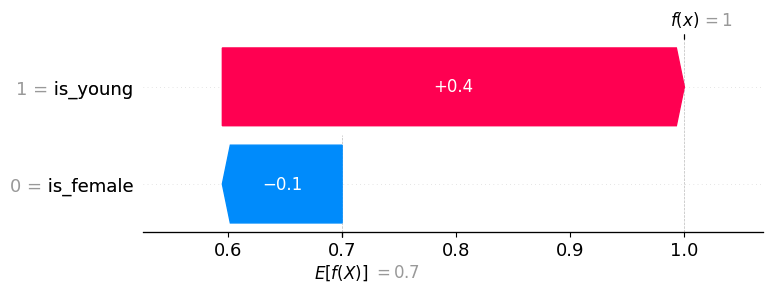

In [ ]:
# waterfall plot for the young boy (background distribution => training set)
shap.plots.waterfall(explanation[0])

### Using only negative examples for the background distribution

The point of this second explanation example is to demonstrate how using a different background distribution can change the allocation of credit among the input features. This happens because we are now comparing the importance of a feature as compared to being someone who died (an adult man). The only thing different about the young boy from someone who died is that the boy is young, so all the credit goes to the `is_young = True` feature.

This highlights that often explanations are clearer when a well-defined background group is used.
In this case, it changes the explanation from "how this sample is different than typical", to "how this sample is different from those who died" (in other words, why did you live?).

In [ ]:
explainer = shap.TreeExplainer(
    model,
    X.loc[y == 0, :],  # background distribution => non-survival
    feature_perturbation="interventional",
)
explanation = explainer(X.loc[[0], :])

# for the young boy:
expected_value = explanation.base_values[0]
shap_values = explanation.values[0]

print(f"explainer.expected_value: {expected_value:.4f}")
print(f"SHAP values for (is_young = True, is_female = False): {shap_values.round(4)}")
print("model output:", (expected_value + shap_values.sum()).round(4))

explainer.expected_value: 0.0000
SHAP values for (is_young = True, is_female = False): [1. 0.]
model output: 1.0


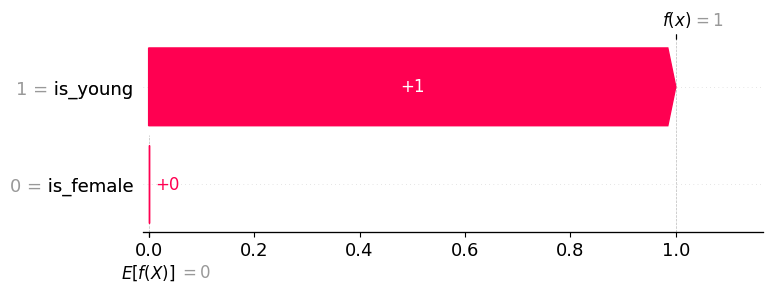

In [ ]:
# waterfall plot for the young boy (background distribution => non-survival)
shap.plots.waterfall(explanation[0])

### Using only positive examples for the background distribution

We could also use only positive examples for our background distribution, and since the difference between the expected output of the model (under our background distribution) and the current output for the young boy is zero, the sum of the SHAP values will be also be zero.

In [ ]:
explainer = shap.TreeExplainer(
    model,
    X.loc[y == 1, :],  # background distribution => survival
    feature_perturbation="interventional",
)
explanation = explainer(X.loc[[0], :])

# for the young boy:
expected_value = explanation.base_values[0]
shap_values = explanation.values[0]

print(f"explainer.expected_value: {expected_value:.4f}")
print(f"SHAP values for (is_young = True, is_female = False): {shap_values.round(4)}")
print("model output:", (expected_value + shap_values.sum()).round(4))

explainer.expected_value: 1.0000
SHAP values for (is_young = True, is_female = False): [ 0.205 -0.205]
model output: 1.0


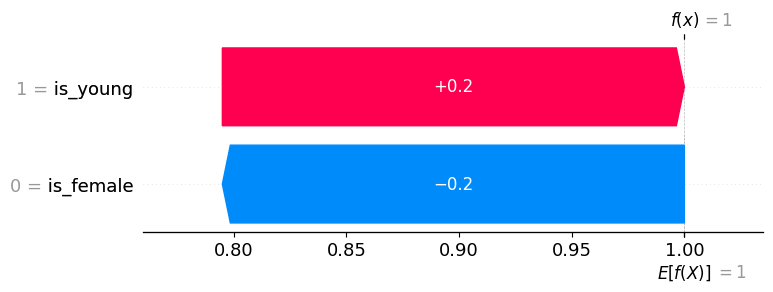

In [ ]:
# waterfall plot for the young boy (background distribution => survival)
shap.plots.waterfall(explanation[0])

### Using young women for the background distribution

If we compare the sample to young women, then neither of the features matter except for adult men, in which both features are given equal credit for their death (as one might intuitively expect).

In [ ]:
explainer = shap.TreeExplainer(
    model,
    np.ones((1, M)),  # background distribution => all young women
    feature_perturbation="interventional",
)
shap_values = explainer.shap_values(X.head(3))
shap_values.round(4)

array([[ 0. ,  0. ],
       [-0.5, -0.5],
       [ 0. ,  0. ]])